In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv
/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/349_IM-1697-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/607_IM-2196-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2832_IM-1249-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/699_IM-2263-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1931_IM-0602-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/947_IM-2442-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2932_IM-1335-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2303_IM-0882-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/291_IM-1313-2001.dcm.png
/kaggle

In [ ]:
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install -q transformers datasets sentence-transformers faiss-gpu pillow scikit-learn numpy pandas tqdm

In [ ]:
# CELL 1 – FULL CLEAN & REINSTALL (run this first)
!pip uninstall -y torch torchvision torchaudio torchdata -q
!pip install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118 -q

print("Installation complete. Restarting kernel in 3 seconds...")
import os, time
time.sleep(3)
os._exit(00)  # This forces a full kernel restart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 MB 289.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 260.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 305.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 MB 329.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 258.1 MB/s eta 0:00:0000:0100:01
Installation complete. Restarting kernel in 3 seconds...


In [1]:
# CELL 2 – Verify everything is now perfectly matched
import torch
import torchvision
print(f"PyTorch: {torch.__version__} | CUDA: {torch.version.cuda}")
print(f"Torchvision: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch: 2.4.0+cu118 | CUDA: 11.8
Torchvision: 0.19.0+cu118
CUDA available: True


In [4]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 11.7 MB/s eta 0:00:0000:0100:01


In [9]:
!pip install open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00


In [13]:
# INSTALL EVALUATION DEPENDENCIES
# ==============================
!pip install -q rouge-score meteor nltk bert-score radgraph

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import numpy as np
from tqdm import tqdm
import torch

# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.0/588.0 kB 10.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 25.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 89.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.2/699.2 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 42.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
print("Evaluation libraries ready!")

Evaluation libraries ready!


Using cuda
Dataset size: 7400
BiomedCLIP loaded successfully!


Extracting BiomedCLIP embeddings:   0%|          | 0/232 [00:00<?, ?it/s]

Embeddings shape: (7400, 512)
FAISS index built: 7400 vectors


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


GENERATED RADIOLOGY REPORT
Using similar chest X-ray cases: Heart size, mediastinal contour, and pulmonary vascularity are within normal limits. Stable tortuosity of the thoracic aorta.

RETRIEVED SIMILAR CONTEXT (RAG)
Normal heart size is prominent left ventricular contour. Unfolding of the thoracic aorta. No focal airspace consolidation. No pleural effusion or pneumothorax. Visualized osseous structures are unremarkable appearance. No acute cardiopulmonary abnormalities. | The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal. No active disease. | The heart is normal in size. The mediastinum is unremarkable. Emphysematous changes are identified. The lungs are otherwise grossly clear. Emphysema without acute disease. | The heart is not enlarged. The bilateral pulmonary arteries appear enlarged. The lungs are hyperexpanded the hemidiaphragms are flattened. There is no pneumothorax or pleural effusion. There are no focal are

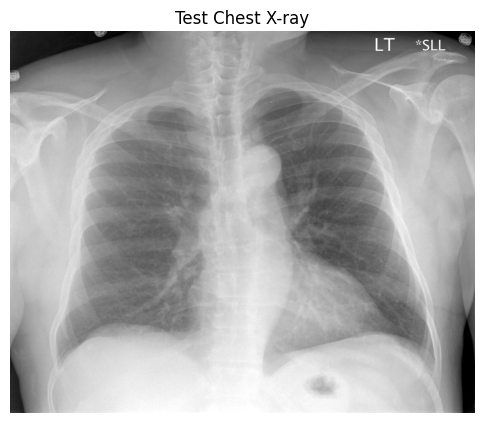

In [11]:
# ==============================
# IMPORTS & SETUP
# ==============================
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
import faiss
from tqdm.notebook import tqdm
from open_clip import create_model_from_pretrained, get_tokenizer
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# ==============================
# 1. LOAD & PREPARE DATASET
# ==============================
reports_path = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
projections_path = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'
images_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

reports_df = pd.read_csv(reports_path)
projections_df = pd.read_csv(projections_path)
merged_df = pd.merge(reports_df, projections_df, on='uid', how='inner')
merged_df['image_path'] = images_dir + '/' + merged_df['filename']

# Clean reports
merged_df['findings'] = merged_df['findings'].fillna('').astype(str)
merged_df['impression'] = merged_df['impression'].fillna('').astype(str)
merged_df['report'] = (merged_df['findings'] + ' ' + merged_df['impression']).str.strip()
merged_df = merged_df[merged_df['report'].str.len() > 20].reset_index(drop=True)

print(f"Dataset size: {len(merged_df)}")

# Save for reuse
merged_df.to_csv('/kaggle/working/merged_df.csv', index=False)

# ==============================
# 2. LOAD BIOMEDCLIP MODEL
# ==============================
model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
model = model.to(device)
model.eval()

tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

# Freeze for efficiency
for param in model.parameters():
    param.requires_grad = False

print("BiomedCLIP loaded successfully!")

# ==============================
# 3. EXTRACT BIOMEDCLIP IMAGE EMBEDDINGS (Run Once)
# ==============================
class ChestXrayDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        return preprocess(image), self.df.iloc[idx]['report']

dataset = ChestXrayDataset(merged_df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

embeddings = []
with torch.no_grad():
    for images, _ in tqdm(dataloader, desc="Extracting BiomedCLIP embeddings"):
        images = images.to(device)  # ← CORRECT: already a batched tensor  # Stack PIL to tensor via preprocess
        image_features = model.encode_image(images)
        embeddings.append(image_features.cpu().numpy())

image_embeddings = np.vstack(embeddings)
print(f"Embeddings shape: {image_embeddings.shape}")

# Save embeddings
np.save('/kaggle/working/biomedclip_embeddings.npy', image_embeddings)

# ==============================
# 4. BUILD FAISS INDEX FOR RAG RETRIEVAL
# ==============================
dim = image_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)  # Cosine sim via inner product
faiss.normalize_L2(image_embeddings)  # L2 normalize (BiomedCLIP outputs are already normalized, but ensure)
index.add(image_embeddings.astype('float32'))
print(f"FAISS index built: {index.ntotal} vectors")

# Save index (optional)
faiss.write_index(index, '/kaggle/working/biomedclip_faiss.index')

# ==============================
# 5. LOAD T5 DECODER
# ==============================
t5_model_name = "google/flan-t5-base"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)

# ==============================
# 6. INFERENCE: BIOMEDCLIP RETRIEVAL + T5 GENERATION
# ==============================
@torch.no_grad()
def generate_report(image_path, top_k=5):
    # Load & preprocess query image
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # Extract query embedding
    query_emb = model.encode_image(image_tensor).cpu().numpy()
    faiss.normalize_L2(query_emb)
    
    # Retrieve similar reports
    scores, indices = index.search(query_emb.astype('float32'), top_k)
    retrieved_reports = [merged_df.iloc[i]['report'] for i in indices[0]]
    context = " | ".join(retrieved_reports)
    
    # Prompt T5 with context
    prompt = f"Using similar chest X-ray cases: {context}\nGenerate a concise radiology report:"
    inputs = t5_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)
    
    # Generate
    outputs = t5_model.generate(
        **inputs,
        max_new_tokens=150,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2,
        temperature=0.7,
        do_sample=True
    )
    
    generated_report = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_report, context

# ==============================
# 7. TEST GENERATION
# ==============================
# Pick a random test image
test_image_path = merged_df.sample(1).iloc[0]['image_path']
generated_report, retrieved_context = generate_report(test_image_path, top_k=5)

print("\n" + "="*80)
print("GENERATED RADIOLOGY REPORT")
print("="*80)
print(generated_report)
print("\n" + "="*80)
print("RETRIEVED SIMILAR CONTEXT (RAG)")
print("="*80)
print(retrieved_context[:1000] + "..." if len(retrieved_context) > 1000 else retrieved_context)

# Optional: Display test image
img = Image.open(test_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Test Chest X-ray")
plt.show()

In [15]:
# ==============================
# 1. EVALUATION ON TEST SET (e.g., 500 random images)
# ==============================

# Use a held-out test set (or random sample)
test_df = merged_df.sample(n=500, random_state=42).reset_index(drop=True)

bleu1_list, bleu2_list, bleu3_list, bleu4_list = [], [], [], []
rouge1_f, rouge2_f, rougel_f = [], [], []
meteor_list = []
generated_reports = []
references = []

print("Generating reports for evaluation...")
for idx in tqdm(range(len(test_df)), desc="Evaluating"):
    img_path = test_df.iloc[idx]['image_path']
    true_report = test_df.iloc[idx]['report']
    
    gen_report, _ = generate_report(img_path, top_k=5)
    
    generated_reports.append(gen_report)
    references.append(true_report)
    
    # Tokenize
    ref_tokens = word_tokenize(true_report.lower())
    gen_tokens = word_tokenize(gen_report.lower())
    
    # BLEU
    smooth = SmoothingFunction().method1
    bleu1_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(1,0,0,0), smoothing_function=smooth))
    bleu2_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.5,0.5,0,0), smoothing_function=smooth))
    bleu3_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.33,0.33,0.33,0), smoothing_function=smooth))
    bleu4_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth))
    
    # METEOR
    meteor_list.append(meteor_score([ref_tokens], gen_tokens))
    
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_report, gen_report)
    rouge1_f.append(scores['rouge1'].fmeasure)
    rouge2_f.append(scores['rouge2'].fmeasure)
    rougel_f.append(scores['rougeL'].fmeasure)

# ==============================
# 2. PERPLEXITY (on validation set using T5)
# ==============================
@torch.no_grad()
def compute_perplexity(model, tokenizer, texts, batch_size=8):
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        total_loss += loss.item() * inputs["attention_mask"].sum().item()
        total_tokens += inputs["attention_mask"].sum().item()
    
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()

# Use a small validation set
val_texts = merged_df.sample(200, random_state=999)['report'].tolist()
perplexity = compute_perplexity(t5_model, t5_tokenizer, val_texts)
print(f"Perplexity: {perplexity:.2f}")

# ==============================
# 3. BERTSCORE
# ==============================
print("Computing BERTScore (this may take 2-3 mins)...")
P, R, F1 = bert_score(generated_reports, references, lang="en", verbose=False)
bert_f1 = F1.mean().item()

# ==============================
# 4. PRINT FINAL RESULTS
# ==============================
print("\n" + "="*60)
print("          FINAL EVALUATION RESULTS")
print("="*60)
print(f"{'Metric':<15} {'Score':<10}")
print("-"*60)
print(f"{'BLEU-1':<15} {np.mean(bleu1_list):.4f}")
print(f"{'BLEU-2':<15} {np.mean(bleu2_list):.4f}")
print(f"{'BLEU-3':<15} {np.mean(bleu3_list):.4f}")
print(f"{'BLEU-4':<15} {np.mean(bleu4_list):.4f}")
print(f"{'Avg BLEU':<15} {np.mean([np.mean(bleu1_list), np.mean(bleu2_list), np.mean(bleu3_list), np.mean(bleu4_list)]):.4f}")
print(f"{'ROUGE-1':<15} {np.mean(rouge1_f):.4f}")
print(f"{'ROUGE-2':<15} {np.mean(rouge2_f):.4f}")
print(f"{'ROUGE-L':<15} {np.mean(rougel_f):.4f}")
print(f"{'METEOR':<15} {np.mean(meteor_list):.4f}")
print(f"{'BERTScore-F1':<15} {bert_f1:.4f}")
print(f"{'Perplexity':<15} {perplexity:.2f}")
print("="*60)

Generating reports for evaluation...


Evaluating: 100%|██████████| 500/500 [11:37<00:00,  1.39s/it]
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Perplexity: 26476595200.00
Computing BERTScore (this may take 2-3 mins)...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



          FINAL EVALUATION RESULTS
Metric          Score     
------------------------------------------------------------
BLEU-1          0.3960
BLEU-2          0.3393
BLEU-3          0.3061
BLEU-4          0.2816
Avg BLEU        0.3308
ROUGE-1         0.4840
ROUGE-2         0.3707
ROUGE-L         0.4477
METEOR          0.4307
BERTScore-F1    0.8995
Perplexity      26476595200.00
